# Income Classifier on Adult Dataset

Classifier to predict whether someone will have income ">50K".

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
from aif360.datasets import AdultDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


## 2. Load the Adult Dataset

In [2]:
dataset = AdultDataset()

df = pd.DataFrame(dataset.features, columns=dataset.feature_names)
df['income'] = dataset.labels.ravel() # Converts to 1D array

print(f"Dataset shape: {df.shape}")
print(df.head(30))
print(f"Income distribution:")
print(df['income'].value_counts())

Dataset shape: (45222, 99)
     age  education-num  race  sex  capital-gain  capital-loss  \
0   25.0            7.0   0.0  1.0           0.0           0.0   
1   38.0            9.0   1.0  1.0           0.0           0.0   
2   28.0           12.0   1.0  1.0           0.0           0.0   
3   44.0           10.0   0.0  1.0        7688.0           0.0   
4   34.0            6.0   1.0  1.0           0.0           0.0   
5   63.0           15.0   1.0  1.0        3103.0           0.0   
6   24.0           10.0   1.0  0.0           0.0           0.0   
7   55.0            4.0   1.0  1.0           0.0           0.0   
8   65.0            9.0   1.0  1.0        6418.0           0.0   
9   36.0           13.0   1.0  1.0           0.0           0.0   
10  26.0            9.0   1.0  0.0           0.0           0.0   
11  48.0            9.0   1.0  1.0        3103.0           0.0   
12  43.0           14.0   1.0  1.0           0.0           0.0   
13  20.0           10.0   1.0  1.0           0.0 

## 3. Preprocess the Data and Binarize Age

age                               False
education-num                     False
race                              False
sex                               False
capital-gain                      False
                                  ...  
native-country=Trinadad&Tobago    False
native-country=United-States      False
native-country=Vietnam            False
native-country=Yugoslavia         False
income                            False
Length: 99, dtype: bool
Missing data in 'age' column: 0
Age median: 37.0
Binarized age distribution:
age_binary
0    23027
1    22195
Name: count, dtype: int64
Features shape: (45222, 98)
Target shape: (45222,)
Feature names: ['education-num', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov', 'workclass=Private', 'workclass=Self-emp-inc', 'workclass=Self-emp-not-inc', 'workclass=State-gov', 'workclass=Without-pay', 'education=10th', 'education=11th', 'education=12th', 'education=1st-4th', 'ed

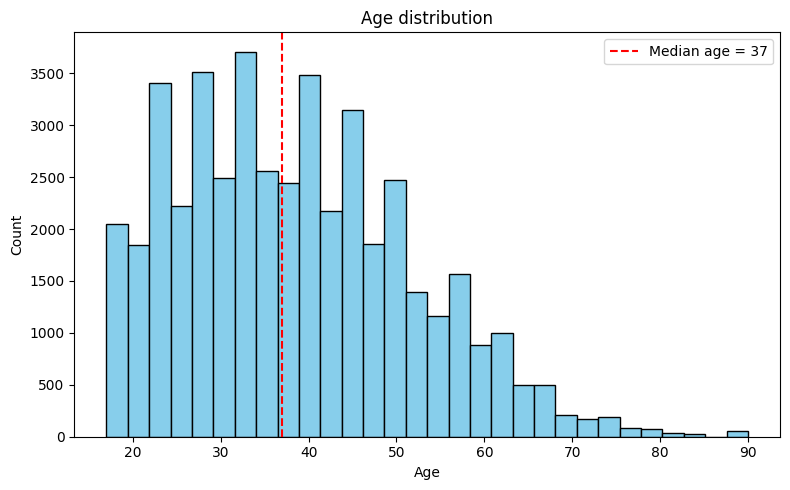

In [3]:
# TODO: add "mean" value for binarizing age threshold for comparison

print(df.isna().any())

missing_data = df['age'].isnull().sum()
print(f"Missing data in 'age' column: {missing_data}")

age_median = df['age'].median() # will be the threshold for binarization
print(f"Age median: {age_median}")

df['age_binary'] = (df['age'] > age_median).astype(int)

print(f"Binarized age distribution:")
print(df['age_binary'].value_counts())

# Drop the original age column and use the binarized version
X = df.drop(['income', 'age'], axis=1)  # all the features that the model will use for prediction
y = df['income'] # what we are trying to predict

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {list(X.columns)}")

# Histogram visualization for age distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df['age'].dropna(), bins=30, color='skyblue', edgecolor='k')
plt.axvline(age_median, color='red', linestyle='--', label=f'Median age = {int(age_median)}')
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Split Data into Train, Validation, and Test Sets

In [4]:
#TODO : test with different split percentages and compare results
# Split: 60% train, 20% validation, 20% test
# First split: 60% train, 40% temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y #stratify to maintain class distribution : important for imbalanced datasets
)

# Second split: Split temp into 50% validation, 50% test (20% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"Class distribution in training set:")
print(y_train.value_counts(normalize=True))
print(f"Class distribution in validation set:")
print(y_val.value_counts(normalize=True))
print(f"Class distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set size: 27133 (60.0%)
Validation set size: 9044 (20.0%)
Test set size: 9045 (20.0%)
Class distribution in training set:
income
0.0    0.752147
1.0    0.247853
Name: proportion, dtype: float64
Class distribution in validation set:
income
0.0    0.752211
1.0    0.247789
Name: proportion, dtype: float64
Class distribution in test set:
income
0.0    0.752128
1.0    0.247872
Name: proportion, dtype: float64


## 5. Feature Scaling

The idea is to put features on a similar scale so that no single feature dominates the learning process due to its magnitude. This is especially important for algorithms like Logistic Regression, which are sensitive to the scale of input features.

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # computes mean and std, then scales
X_val_scaled = scaler.transform(X_val) # scales validation set
X_test_scaled = scaler.transform(X_test) # scales test set

print("Features scaled using StandardScaler")
print(f"Training set scaled shape: {X_train_scaled.shape}")
print(f"Validation set scaled shape: {X_val_scaled.shape}")
print(f"Test set scaled shape: {X_test_scaled.shape}")

Features scaled using StandardScaler
Training set scaled shape: (27133, 98)
Validation set scaled shape: (9044, 98)
Test set scaled shape: (9045, 98)


## 6. Train the Classifier

In [6]:
#TODO :test with different models and compare results
#TODO : save models into .pth files, reusable in further notebooks.
# Logistic Regression
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_train_scaled, y_train)
print("Logistic Regression trained")

#TODO : visualize training error epochs / training metrics too (accuracy, precision, recall, f1-score)

Logistic Regression trained


## 7. Measure Performance on Validation Set

In [7]:
# TODO : add confusion matrix visualization
# Predict on validation set
y_val_pred = lr_classifier.predict(X_val_scaled)

# Calculate validation metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print("VALIDATION SET PERFORMANCE")
print("="*50)
print(f"Accuracy:  {val_accuracy:.4f}")
print(f"Precision: {val_precision:.4f}")
print(f"Recall:    {val_recall:.4f}")
print(f"F1-Score:  {val_f1:.4f}")

print("Detailed Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['<=50K', '>50K']))

VALIDATION SET PERFORMANCE
Accuracy:  0.8470
Precision: 0.7330
Recall:    0.6015
F1-Score:  0.6608
Detailed Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      6803
        >50K       0.73      0.60      0.66      2241

    accuracy                           0.85      9044
   macro avg       0.80      0.76      0.78      9044
weighted avg       0.84      0.85      0.84      9044



In [8]:
#TODO : visualize training and validation error evolution over epochs

## 8. Measure Performance on Test Set

In [9]:
# Predict on test set
y_test_pred = lr_classifier.predict(X_test_scaled)

# Calculate test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("TEST SET PERFORMANCE")
print("="*50)
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")

print("Detailed Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['<=50K', '>50K']))


TEST SET PERFORMANCE
Accuracy:  0.8442
Precision: 0.7272
Recall:    0.5946
F1-Score:  0.6542
Detailed Classification Report:
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      6803
        >50K       0.73      0.59      0.65      2242

    accuracy                           0.84      9045
   macro avg       0.80      0.76      0.78      9045
weighted avg       0.84      0.84      0.84      9045

